# `AA: Workshop 11` - Dimensionality Reduction and Recommender Systems

In this notebook we focus on two things:
First, dimensionality reduction using PCA and second collaborative filtering, a technique which is commonly used in online marketing (e.g.) for recommender systems.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline

iris = pd.read_csv('../data/iris.csv', index_col="number").dropna(axis=0)
cancer = pd.read_csv('../data/breast_cancer.csv', index_col="id").dropna(axis=0)
X = iris.drop("Species", axis=1)
y = iris["Species"]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

## Principal Component Analysis (PCA)
In the case of the iris dataset, we have just four features - an amount we can still easily manage. But imagine we have a much larger features space. Then, it might be necessary to reduce the dimensionality of our dataset. Also, we gain another advantage: We can visualize the data more easily! As you have seen above, already with just 4 dimensions it is hard to visualize our data in a meaningful way. The size of a pairplot increases quadratically with the number of features. For four features we have sixteen plots (more than you should expect any stakeholder to have a look at/understand ...), but for 10 features it is already a hundred. (way more than you would like to have to look at!)

So, how do we reduce the dimensionality of our dataset without losing two much information? (unfortunately, we are always losing some.)


Principal component analysis (PCA) is the way to go! Using PCA, we are looking at our data and try to find a projection, which keeps most of the variance within the data. As this is a little theoretical, let's have a quick look at graphical example:

![pca](pca.png)

Here, our data originally had two dimensions and is reduced onto just one dimension. As you can see, most of the variance of our data is conserved. If the datapoints are very crooked in space, it is a little harder to find the "principal components". For this, there arer advanced options like for example Kernel-PCA (which we are not talking about in this course). 

Furthermore, there is one more important application for PCA: When there are more features than records in your dataset, you can reduce the dimensionality of your dataset to the number of records without losing any information! So if you have 1 million features but only 100 records, then it is sufficient to look at only the first 100 principal components and you will not have lost any variance. Still, it can be useful to reduce the number of dimensions further in case that you do not lose too much variance.

As a rule of thumb, there should be at least 95% of the original variance left in the dataset. Let's now run a PCA on our iris dataset and have a look at the principal components.

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

In [8]:
pca.components_

array([[ 0.52393408, -0.25118224,  0.58291953,  0.56798361]])

In [5]:
print(pca.explained_variance_ratio_[0])

0.7238126221451703


In [6]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

In [9]:
print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

[0.72381262 0.234708  ]
0.9585206187942084


Using only two principal components, we still have approx. 96% of our variance, so we can assume that the transformed dataset is a good approximation of our original dataset. Let's now have a closer look at how each of these two principal components is composed.

In [10]:
print(pca2.components_)
print(list(X_scaled_df.columns)[:4])

[[ 0.52393408 -0.25118224  0.58291953  0.56798361]
 [ 0.3682453   0.92780742  0.01173928  0.05857464]]
['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']


In [11]:
iris_pca = pd.DataFrame(X_pca2, columns=["First PC", "Second PC"], index=iris.index)
iris_pca["Species"] = iris["Species"]
iris_pca.head()

,First PC,Second PC,Species
number,,,
1,-2.202027,0.491347,setosa
2,-2.046510,-0.651115,setosa
3,-2.322926,-0.321927,setosa
4,-2.263907,-0.576317,setosa
5,-2.323567,0.656277,setosa


Before running a clustering algorithm on the reduced data, let's first have a look what we would have seen using only one principal component!

<Axes: xlabel='Species', ylabel='First PC'>

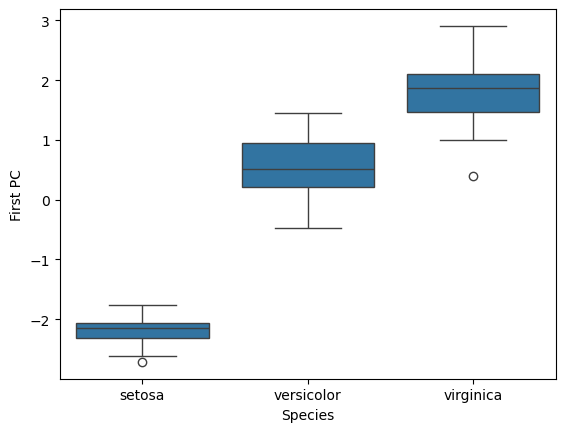

In [12]:
sns.boxplot(x="Species", y="First PC", data=iris_pca)

We are (as expected) already able to differentiate between *setosa* and the other two types easily using just the first principal component. There is a clear difference between the core elements of the other two clusters, but it is not possible to completely differentiate between them.

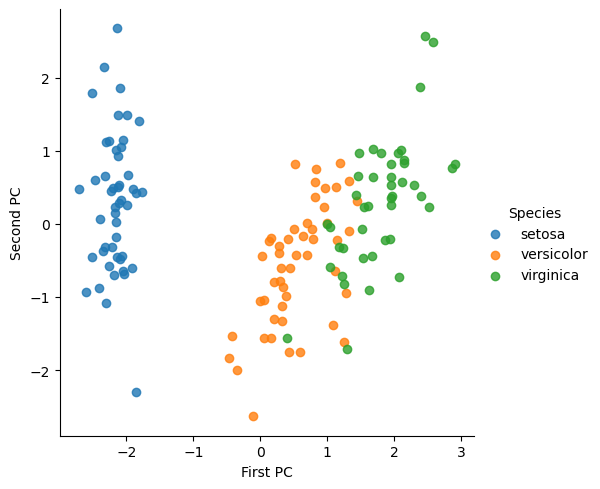

In [13]:
sns.lmplot(x="First PC", y="Second PC", data=iris_pca, fit_reg=False, hue="Species")

Let's now use K-means again to find clusters in this reduced 2-dimensional space! 

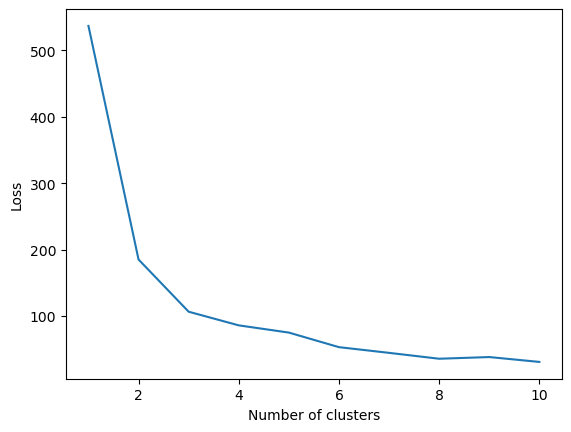

In [18]:
pca_clusters = []
pca_losses = []
k_max = 10

for i in range(k_max):
    model = KMeans(n_clusters=i+1, n_init='auto')
    model.fit(X_pca2)
    pca_clusters.append(i+1)
    pca_losses.append(model.inertia_)
    
plt.plot(pca_clusters, pca_losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

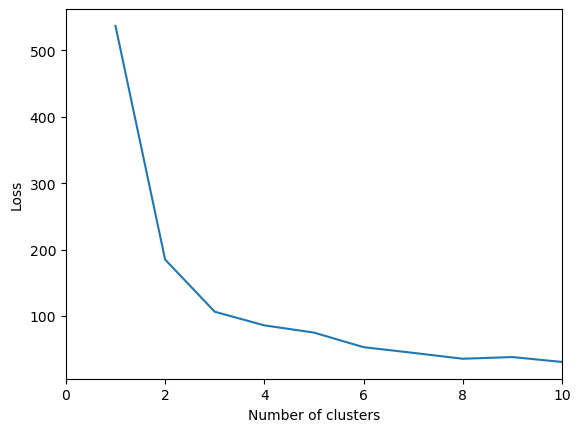

In [19]:
plt.plot(pca_clusters, pca_losses)
plt.xlim([0,10])
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [69]:
pca_three_means = KMeans(n_clusters=3)
pca_three_means.fit(X_pca2)

/Users/janik/miniconda3/envs/AA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

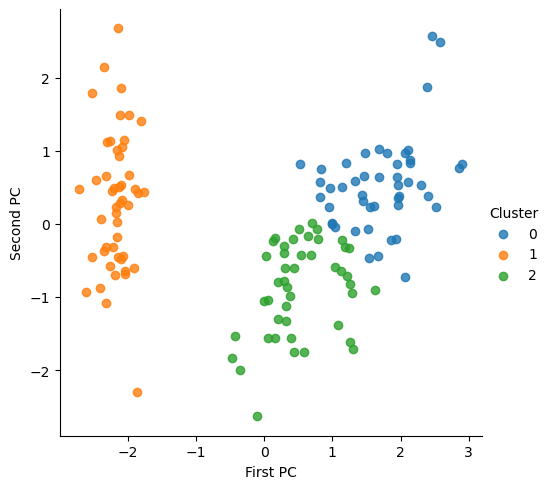

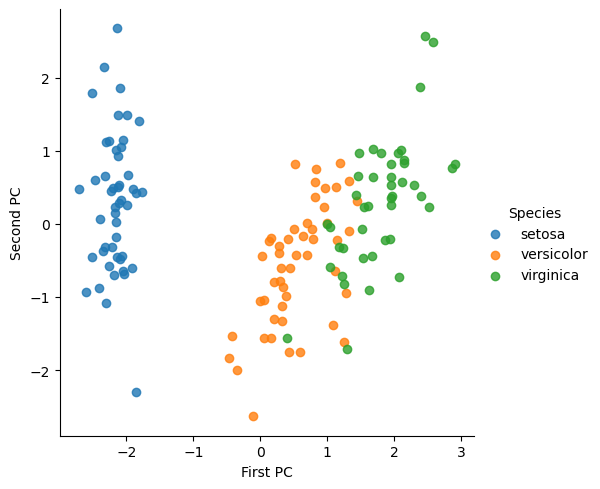

In [21]:
iris_pca["Cluster"] = pca_three_means.predict(X_pca2)
sns.lmplot(x="First PC", y="Second PC", hue="Cluster", data=iris_pca, fit_reg=False)
sns.lmplot(x="First PC", y="Second PC", hue="Species", data=iris_pca, fit_reg=False)

**Exercise:** 
Use all methods for unsupervised learning shown here and try to find clusters in the (prepepared) cancer dataset! 
How many principal components do you need? Can you still plot your data in a meaningful way? Compare this to the real data with labels!
Would you have chosen the number of clusters as 2 without knowing that there are only two cancer types? 

In [70]:
cancer_wo_target = cancer.drop("diagnosis", axis=1)

# YOUR CODE HERE



_______

## Recommender Systems

Recommender systems are ubiquitous in many online sites.  If you've ever been recommended an item to buy, a movie to watch, or a person to follow on social media, you have seen the results of a recommender system.  The goal of recommender systems, broadly speaking, is to suggest items to a user that the system believes this user will like.  This has obvious applications in many online stores, where both the company and the users will likely be happier if the system is able to provide high-quality recommendations.

Broadly speaking, there are a number of sources of information we can use to make predictions about whether a user will like an item.  There is "pure user" information, such as the age, location, profession, etc, of the user; these don't involve any of the items themselves, but just contain information about the user.  There is also "pure item" information (not related to any user, but just to the item); in the case of movies, for instance, this could include things like the movie budget, the genre, the actors, etc.  Finally, there is "user-item" information, which consists of ratings or order history between users and items.  Ideally, we would want to use all of this information to provide as high-quality recommendations as possible to the user.

Although there are techniques that combine all these types of data, in this set of notes we are largely going to focus just on the third type, building recommendation systems that rely only on past user-item information.  This is a setting known as _collaborative filtering_ , and these algorithms will form the basis of the presentation here.

Before we begin our discussion, however, we should emphasize that there are a number of issues that we won't touch on in these notes.  Here we will consider a standard setting where each user "rates" some (usually quite small) some subset of the items.  This is the classical recommender system setting, and forms the intuitive basis for much of the algorithmic work in this area.  However, in reality there are many challenges that arise in this setting that need to be dealt with in actual real-world recommender systems.  For example, users may rarely actually rate items, but instead the mere presence of a user-item order will be the only information we have (so we have no formal indication of the user rating, but we can typically assume that the user orders items they tend to like).  Additionally, when a new user signs up, or a new item is added, there is initially user-item history, so we likely need to integrate some of the user or item-level features in order to form "baseline" predictions in these cases; and in general, there is a question of how much "personalization" we want to offer versus how much we should recommend "generic" good items.




### Collaborative filtering

_Collaborative filtering_ is one way to build recommendation systems, that (at least by the definitions we will use here), only users user-item information in order to make recommendations.  The setting you should have in mind here is that of a matrix, where the rows of the matrix correspond to users, and the columns of the matrix correspond to items.  The entires of the matrix should be though of as ratings for each item, i.e., how much user $i$ with like item $j$.  For example, consider the following matrix
\begin{equation}
X \in \mathbb{R}^{m \times n} = \left [ \begin{array}{cccc}
1 & 1 & 2 & 3 \\
2 & 2 & 5 & 4 \\
2 & 3 & 3 & 5 \\
4 & 2 & 4 & 5 \\
2 & 2 & 4 & 4
\end{array} \right ]
\end{equation}

For example, in this setting user 1 would assign a ratings of 1, 1, 2, 3 to items 1-4 respectively (i.e., the first row of the matrix).  Similar, item 2 has ratings of 1,2,3,2,2 from users 1-5.  The ordering of this matrix is important (rows correspond to users and items correspond to columns), so it's important to be familiar with this notation; note that in this convention there are $m$ users and $n$ items.

Of course, in general, we _won't_ have ratings for every user for every item (this is precisely the problem we're trying to solve).  Rather, we only observe some sparse subset of the entries of $X$, whereas the rest are unknown (denoted by $?$ in the matrix below).
\begin{equation}
X = \left [ \begin{array}{cccc}
1 & ? & ? & 3 \\
? & 2 & 5 & ? \\
? & 3 & ? & 5 \\
4 & ? & 4 & ? \\
2 & 2 & ? & ?
\end{array} \right ]
\end{equation}
The task of collaborative filtering, then, is to "fill in" the remaining entries of this matrix given the observed matrix.  This $X$ matrix that we observed is _sparse_ but the unknown entries do not correspond to actual zeros in the matrix, but are rather just truly unknown.

In the collaborative filtering setting, we want to fill in the remaining entries from the matrix based _only_ upon the observed entries (that is, we don't have additional context such as features for the user or items, but as mentioned above, in typical recommender systems, you _do_ need to consider these other options.

### Example: MovieLens data set

The example we'll use in these notes (and which you'll use in the homework), is the MovieLens data set, a common publicly available data set for collaborative filtering.  The full data set and information is available here: https://grouplens.org/datasets/movielens/.  Although the full MovieLens data set is fairly large, there is a smaller subset available here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip which we'll use for this example.  We can load the data using the following calls (importantly, this is slightly different than you'll need to implement for the homework, but it's useful for our discussion here).

In [44]:
# load MovieLens ratings, keeping only movies with >=5 ratings
df = pd.read_csv("../data/ratings.csv")
df_mov = pd.read_csv("../data/movies.csv", index_col="movieId")

X = np.asarray(sp.coo_matrix((df["rating"], (df["userId"]-1, df["movieId"]-1))).todense())

Note that we're generating a dense matrix of user IDs by movie IDs, and for larger systems you would definitely need to keep the matrix in sparse form.  While this data set was already filtered to only include users who ranked a reasonable number of movies, we're also going to filter it to only include movies with five or more ratings.

In [45]:
valid_movies = (X!=0).sum(axis=0) >= 5
movie_to_title = dict(zip(range(len(valid_movies)), df_mov.loc[np.where(valid_movies)[0]+1]["title"]))
X = X[:,valid_movies]
print(X.shape)

(671, 3496)


Note that in this format, the zero entries correspond to unknown elements, not to actual zero ratings (the ratings only go as low as 0.5).  For instance, we can compute per-user and per-item mean ratings via the following.

In [46]:
# form average rating for each user
user_means = np.array([X[i,X[i,:]!=0].mean() for i in range(X.shape[0])])
movie_means = np.array([X[X[:,i]!=0,i].mean() for i in range(X.shape[1])])

Finally, we can get some basic sense of this dataset by looking at average ratings and average numbers of ratings.

Text(0, 0.5, 'Count')

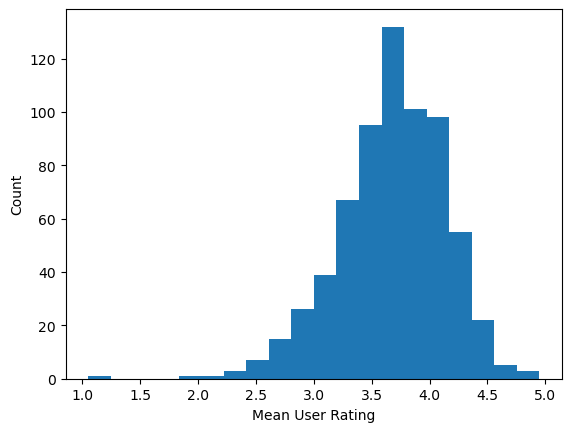

In [47]:
plt.hist(user_means, bins=20)
plt.xlabel("Mean User Rating")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

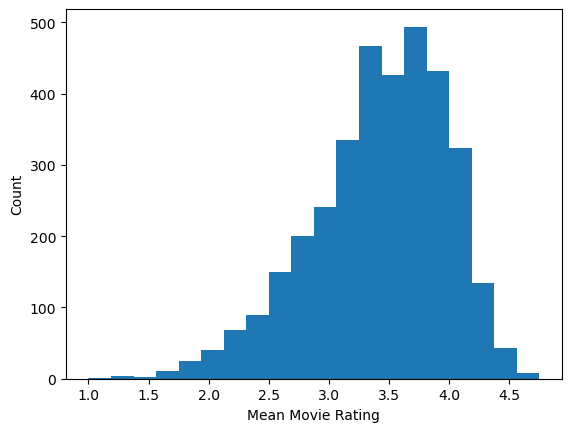

In [48]:
plt.hist(movie_means, bins=20)
plt.xlabel("Mean Movie Rating")
plt.ylabel("Count")

Text(0, 0.5, 'Number of Movies')

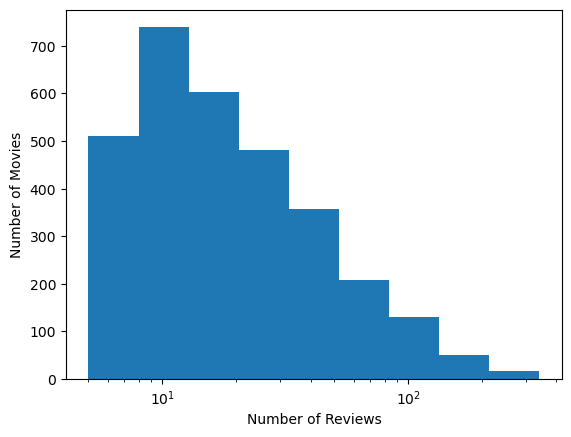

In [49]:
num_reviews = (X!=0).astype(float).sum(axis=0)
plt.hist(num_reviews,bins=np.logspace(np.log10(min(num_reviews)),np.log10(max(num_reviews)),10))
plt.gca().set_xscale("log")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Movies")

Text(0, 0.5, 'Number of Users')

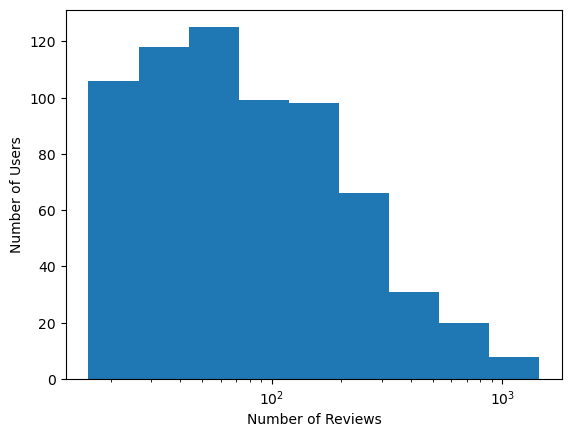

In [50]:
num_reviews = (X!=0).astype(float).sum(axis=1)
plt.hist(num_reviews,bins=np.logspace(np.log10(min(num_reviews)),np.log10(max(num_reviews)),10))
plt.gca().set_xscale("log")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")

Finally, since I know you're likely curious, here are the best and worst reviewed movies.

In [51]:
# best movies
print("\n".join([movie_to_title[a] for a in np.argsort(movie_means)[-5:]]))

Love & Human Remains (1993)
Diabolique (Les diaboliques) (1955)
Paperman (2012)
Ikiru (1952)
Anne Frank Remembered (1995)


In [52]:
# worst movies
print("\n".join([movie_to_title[a] for a in np.argsort(movie_means)[:5]]))

Joe's Apartment (1996)
After Earth (2013)
Battlefield Earth (2000)
Max Payne (2008)
Cats & Dogs (2001)


### Historical note: the Netflix Prize

The field of collaborative filtering received a substantial boost in popularity during the late 2000s after the annoucement of the Netflix Prize.  This was a public competition where Netflix released a large dataset of about 100 million ratings, and challenged the public to come up with a method that improved, by 10% according to RMSE, upon their existing solution (which relied upon item-item Pearson correlation, plus some linear regression methods).

Though there were some notable issues with the Netflix Prize, the competition had a huge impact on the field of data science.  Although there were many prior data competitions of a similar form (the KDD conference had been running the KDDCup for many years), this was the competition that really put "machine learning competitions" into the public eye.  Companies like Kaggle were started largely due to the success of this competition, and many later contests like the ImageNet challenge were likely directly or indirectly influenced by it.  Furthermore, the ubiquity of ensemble methods (not as in algorithm like boosting or bagging, but as in combining many disparate models to form overall better predictions) was heavily influenced by the competition, where all the top teams used ensemble methods.  Finally, it was an amazing stroke of luck that the target of 10% improvement seemed to be almost _exactly_ what was possible combining a huge variety of methods; the competition could have easily taken a few months or still be running today if the data had offered only a slightly lower or slightly higher possible level of performance.

### Types of collaborative filtering algorithms

While there are several possible algorithms for collaborative filtering, broadly speaking most of them fit into one of three different categories:

- **User-user approaches:**  In this approach we estimate a user's rating of an item by finding "similar" users and then looking at their predictions for this item.
- **Item-item approaches:** These methods take the converse approach, and estimate a user's rating of a item by finding similar items and then looking at the user's rating of these similar items.
- **Matrix factorization**: Finally, the last class of approaches works a little bit differently, by aiming to construct a _low-rank_ matrix that approximates the observed entries of the rating matrix.

We'll discuss each of these in turn, and look at how they can be implemented on the MovieLens data set (except for matrix factorization, which is one of the homework assignments).

## User-user methods

As mentioned above, the key idea of the user-user approach is that in order to predict an unknown user-item score, we're going to find "similar" users, and then look at how they scored that item.  To compute similar users, we can use common techniques like correlation coefficient, cosine_similarity, etc, with the caveat that these metrics typically assume fixed-sized vectors with no unknown elements, so some changes are typically needed to apply to the collaborative filtering setting.

To start, let's introduce a slightly more formal bit of notation to define our problem.  Let $\hat{X}_{ij}$ denote our prediction for the $i$th user and $j$th item (i.e., this will be one of the elements that is missing from the matrix $X$, which we want to predict).  A common form for the prediction make by the user-user approach would be
\begin{equation}
\hat{X}_{ij} = \bar{x}_i + \frac{\sum_{k:X_{kj} \neq 0} w_{ik} (X_{kj} - \bar{x}_k)}{\sum_{k:X_{kj} \neq 0} \lvert w_{ik} \rvert}
\end{equation}
where $\bar{x}_i$ denotes the average of the observed ratings for user $i$, and $w_{ik}$ denotes a _similarity weight_ between user $i$ and user $k$ (which we will define shortly).  The intuition behind this approach is the following: if we want to predict user $i$'s rating for item $j$, we look across all users that _do_ have ratings for item $j$, and we average these together, weighted by a similarity function between the two users (we divide by $\sum_{k:X_{kj} \neq 0} \lvert w_{ik} \rvert$ so that we are taking a weighted average, noting that we take the absolute value because similarity weights can sometimes be positive or negative depending how we define then).  Because user's also frequently have their own "baseline" rating (i.e., some users naturally assign lower ratings than others), it's slightly better to do this modeling in the "difference space", the difference between a user's rating and their mean rating, and then add re-scale by adding a user's mean score.

Let's see how this works in code.  For now, let's suppose we have all the user/user weights in the $W \in \mathbb{R}^{m \times m}$ (remember, by our convention there are $m$ users), which we'll discuss more shortly.  But assuming we have these weights, we can make a prediction by the following code.

In [53]:
def predict_user_user(X, W, user_means, i, j):
    """ Return prediction of X_(ij). """
    return user_means[i] + (np.sum((X[:,j] - user_means) * (X[:,j] != 0) * W[i,:]) / 
                            np.sum((X[:,j] != 0) * np.abs(W[i,:])))

Assuming a similarity matrix of all ones, let's see how the system predict that user 0 and user 10 would score two different movies.

In [54]:
W = np.ones((X.shape[0], X.shape[0]))
print("User: 0, ", movie_to_title[0], predict_user_user(X, W, user_means, 0, 0))
print("User: 10, ", movie_to_title[0], predict_user_user(X, W, user_means, 10, 0))
print("User: 0, ", movie_to_title[1], predict_user_user(X, W, user_means, 0, 1))
print("User: 10, ", movie_to_title[1], predict_user_user(X, W, user_means, 10, 1))

User: 0,  Toy Story (1995) 2.761825952305907
User: 10,  Toy Story (1995) 4.270649481717672
User: 0,  Jumanji (1995) 2.3795682008264385
User: 10,  Jumanji (1995) 3.888391730238203


Since computing predictions one at a time is fairly slow, let's see how we can form all the predictions for a user simultaneously (note that we add a small constant to the denominator to cover the case where there is no user (with non-zero weight), who has previously rated the item.

In [55]:
def predict_user_user(X, W, user_means, i):
    """ Return prediction of X_(ij). """
    return user_means[i] + (np.sum((X - user_means[:,None]) * (X != 0) * W[i,:,None], axis=0) / 
                            (np.sum((X != 0) * np.abs(W[i,:,None]), axis=0) + 1e-12))

(array([  2.,   0.,   8.,  19.,  24.,  38.,  79., 111., 174., 219., 311.,
        428., 483., 588., 503., 326., 144.,  27.,   9.,   3.]),
 array([0.18584366, 0.36845086, 0.55105807, 0.73366528, 0.91627248,
        1.09887969, 1.2814869 , 1.4640941 , 1.64670131, 1.82930852,
        2.01191572, 2.19452293, 2.37713014, 2.55973734, 2.74234455,
        2.92495175, 3.10755896, 3.29016617, 3.47277337, 3.65538058,
        3.83798779]),
 <BarContainer object of 20 artists>)

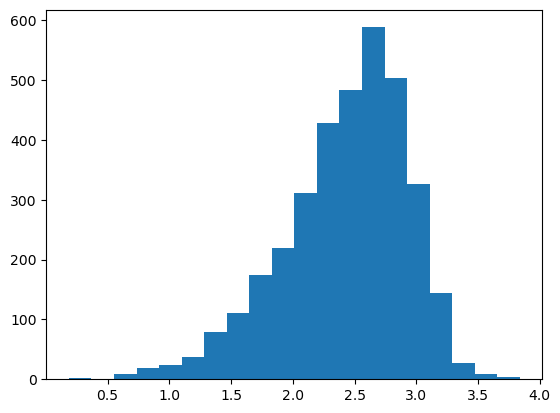

In [56]:
plt.hist(predict_user_user(X, W, user_means, 0), bins=20)

### Computing weights

Of course (since the weights are all equal) we aren't doing too much here, mainly just computing average scores based upon a user's mean and the average rating that other reviewers have assigned to a movie.  Instead, for this method to be effective, we want to compute a weight matrix that somehow captures the similarity between two users.  Because the only information we have in collaborative filtering is based upon the user-item ratings (i.e., we don't have user-centric features that could be used to compute a similarity between users), the main way that we can build a similiarty score is by looking at some kind of correlation between the two sets of ratings; but since two users haven't necessarily rated the same movies, it is common to compute these correlations _only for the set of movies that both have reviewed_.  We'll consider a few examples of such weighting schemes.

**Pearson correlation** Let's take the standard example of Pearson correlation (one of the most common methods for defining these weights).  First, let $\mathcal{I}_{ik}$ be the set of movies that user $i$ and user $k$ both rated
\begin{equation}
\mathcal{I}_{ik} = \{ j : X_{ij} \neq 0, X_{kj} \neq 0 \}
\end{equation}
The Pearson correlation between two users gives the weight
\begin{equation}
W_{ik} = \frac{\sum_{j \in \mathcal{I}_{ij}} (X_{ij} - \bar{x}_i)(X_{kj} - \bar{x}_k)}
{\sqrt{\sum_{j \in \mathcal{I}_{ij}}(X_{ij} - \bar{x}_i)^2} \sqrt{\sum_{j \in \mathcal{I}_{ij}}(X_{kj} - \bar{x}_k)^2}}
\end{equation}
which is just the normal Pearson correlation coefficient but only computed over the items where both users rated the item.

The Pearson correlation can be computed via the following function (we add $10^{-12}$ to the denominator to not cause the result to be undefined when the users have no overlap in items).

In [57]:
def pearson(X,user_means, i,j):
    I = (X[i,:]!=0) * (X[j,:]!=0)
    xi = X[i,I] - user_means[i]
    xj = X[j,I] - user_means[j]
    return (xi @ xj)/(np.sqrt((xi @ xi)*(xj @ xj))+1e-12)
pearson(X,user_means, 1, 2)

-0.009772301207775976

However, as before, it's inefficient to compute these individually for each pair of users.  The following function computes the same quantity for all users via the standard matrix tricks.

In [58]:
def all_pearson(X,user_means):
    X_norm = (X - user_means[:,None])*(X != 0)
    X_col_norm = (X_norm**2) @ (X_norm != 0).T
    return (X_norm @ X_norm.T)/(np.sqrt(X_col_norm*X_col_norm.T)+1e-12)
W_pearson = all_pearson(X, user_means)
W[1,2]

1.0

One downside to the standard pearson correlation as defined above is that if users have a very small number of items in common (often, just 1), then their Pearson correlation is either 1 or -1.  This is almost certainly not what is wanted, so it's common to require some minimum number of items in common, and set the weight to zero otherwise.

In [59]:
def all_pearson(X, user_means, min_common_items=5):
    X_norm = (X - user_means[:,None])*(X != 0)
    X_col_norm = (X_norm**2) @ (X_norm != 0).T
    common_items = (X!=0).astype(float) @ (X!=0).T
    return (X_norm @ X_norm.T)/(np.sqrt(X_col_norm*X_col_norm.T)+1e-12) * (common_items >= min_common_items)
W_pearson = all_pearson(X, user_means)
W[1,2]

1.0

**Cosine similarity** The standard cosine similarity is also fairly common to use as a weight, and differs in that (under the usual definition), we _don't_ subtract off the mean before computing the similarity.  It is defined as follows
\begin{equation}
W_{ik} = \frac{\sum_{j=1}^n X_{ij}X_{kj}}{\sqrt{\sum_{j=1}^n X_{ij}^2} \sqrt{\sum_{j=1}^n X_{kj}^2}}
\end{equation}
Notice that (again, in the common definition of cosine similarity for collaborative filtering) we also don't explicitly sum over only the elements where the the user both rated an item.  Because we treat missing entries in the matrix as zeros here, these terms won't factor in to the numerator (any items where both users did not rate an item will be zero), but the denominator _is_ affected by the total number of items each user rated.  Thus, if two users both rated a large number of items but their overlap is small, the cosine similarity would be smaller than in the case where they both rated a small number of items that have the number number of overlaping items.  Thus, we usually don't need to explicitly filter for users that have some minimum number of items in common, as we did with Pearson correlation.

The following code will compute the cosine similarity (this time just directly adopting the setting of computing all similarities simultaneously).

In [60]:
def all_cosine(X):
    x_norm = np.sqrt((X**2).sum(axis=1))
    return (X @ X.T) / np.outer(x_norm, x_norm)
W_cosine = all_cosine(X)

**Nearest neighbors** After computing one of the above similarity measures (or other similar measures), it's fairly common to look _only_ at some $K$ users that are most similar to a given user, rather than a sum over all users.  This is equivalent to setting the lower entries of $W$ to all be zero, i.e.,
\begin{equation}
\tilde{W}_{ik} = \left \{ \begin{array}{ll}W_{ik} & \mbox{ if $\lvert W_{ik} \rvert$ is amongst top $K$ values for user $i$} \\
0 & \mbox{ otherwise} \end{array} \right .
\end{equation}
Doing so effectively looks just at the most similar users (i.e., the "nearest neighbors") of user $i$, instead of all other users.  The downside of this approach is that if our data matrix is very sparse, we may not find _any_ other users that have ratings for some new item $i$, based upon only the neareast neighbors.  This could be fixed by considering only those nearest neighbors that _do_ have a given item, but this is computationally more expensive, since we need to recompute neighbors for each item, instead of once per user.

For any existing weight matrix we can limit it to the nearest neightbors with the following function.

In [61]:
def nearest_neighbors(W, K):
    W_neighbors = W.copy()
    W_neighbors[W < np.percentile(np.abs(W), 100-100*K/X.shape[0], axis=0)] = 0
    return W_neighbors
W_pearson_100 = nearest_neighbors(W_pearson, 100)

We're not going to rigorously evaluate the performance of the approach, but we can apply the approaches by just plugging in these weights into the functions we considered above.

(array([5.000e+00, 3.000e+00, 7.000e+00, 1.600e+01, 3.300e+01, 6.000e+01,
        1.410e+02, 3.170e+02, 7.470e+02, 1.083e+03, 6.320e+02, 2.610e+02,
        9.000e+01, 4.800e+01, 2.300e+01, 1.300e+01, 7.000e+00, 4.000e+00,
        5.000e+00, 1.000e+00]),
 array([-0.38957182, -0.0767379 ,  0.23609601,  0.54892993,  0.86176385,
         1.17459777,  1.48743169,  1.80026561,  2.11309953,  2.42593345,
         2.73876736,  3.05160128,  3.3644352 ,  3.67726912,  3.99010304,
         4.30293696,  4.61577088,  4.9286048 ,  5.24143872,  5.55427263,
         5.86710655]),
 <BarContainer object of 20 artists>)

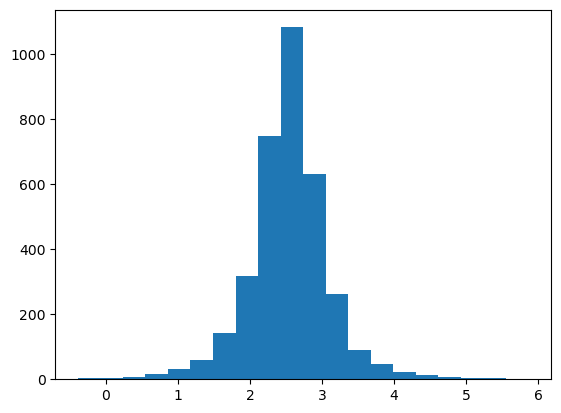

In [62]:
plt.hist(predict_user_user(X, W_pearson, user_means, 0), bins=20)

Using the Pearson correlation produces a great deal more spread in the prediction than in our previous case where we had unit weights.  Note that beacuse the weights can be negative, and we're modeling a difference, it's completely possible to get ratings outside the allowable range (in practice, we'd simply clip them in this case).  Let's look at the case where we use just the 100 nearest neighbors to make the prediction.

(array([1.000e+00, 3.000e+00, 1.000e+00, 1.500e+01, 2.000e+01, 1.700e+01,
        7.000e+00, 1.160e+02, 5.300e+01, 7.100e+01, 3.800e+01, 3.220e+02,
        2.156e+03, 2.000e+02, 1.390e+02, 2.320e+02, 5.300e+01, 3.600e+01,
        5.000e+00, 1.100e+01]),
 array([-0.68715415, -0.42944217, -0.17173019,  0.08598179,  0.34369377,
         0.60140574,  0.85911772,  1.1168297 ,  1.37454168,  1.63225366,
         1.88996564,  2.14767762,  2.4053896 ,  2.66310158,  2.92081355,
         3.17852553,  3.43623751,  3.69394949,  3.95166147,  4.20937345,
         4.46708543]),
 <BarContainer object of 20 artists>)

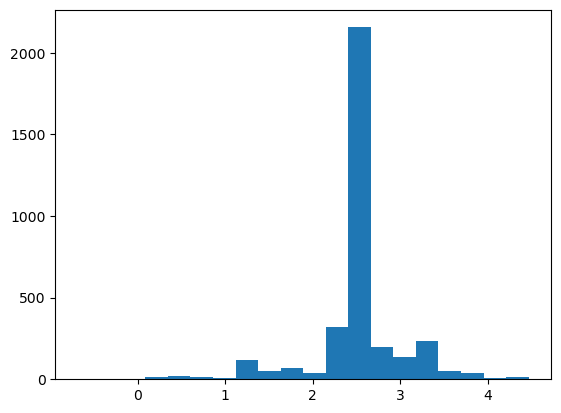

In [63]:
plt.hist(predict_user_user(X, W_pearson_100, user_means, 0), bins=20)

What's happening here is that if we restrict ourselves to only the 100 nearest neighbors of a given user $i$, then there are many cases were we don't have any overlap with user who predict the for some item, so we make the mean prediction much more (this is intentially a user for this this is a large difference, other users have less difference, if they happen to have neighbors that rate a more diverse set of items).  Finally, let's look at the cosine similarity-based predictions.

(array([  2.,  10.,  24.,  30.,  56., 111., 168., 238., 356., 468., 607.,
        661., 462., 236.,  55.,   9.,   2.,   0.,   0.,   1.]),
 array([-0.03860759,  0.20456476,  0.44773712,  0.69090948,  0.93408183,
         1.17725419,  1.42042655,  1.6635989 ,  1.90677126,  2.14994362,
         2.39311597,  2.63628833,  2.87946069,  3.12263304,  3.3658054 ,
         3.60897776,  3.85215011,  4.09532247,  4.33849483,  4.58166718,
         4.82483954]),
 <BarContainer object of 20 artists>)

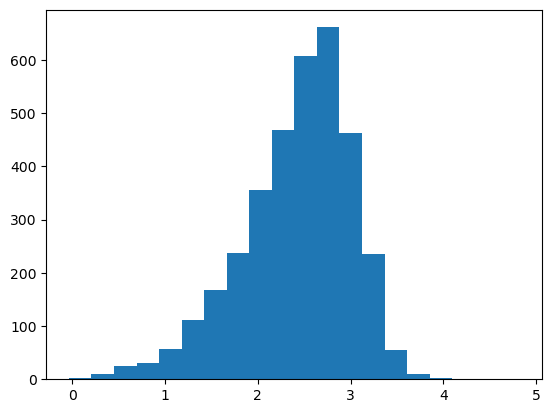

In [64]:
plt.hist(predict_user_user(X, W_cosine, user_means, 0), bins=20)

## Item-item approaches

We'll mention item-item approaches only very briefly here, because the math is essentially identical to the user-user case, just with the matrices transposed.  Whereas the user-user approach was based upon which _users_ were similar to a given user, the item-item approach is based upon what _items_ are similar to a given item.  More formally, to make a prediction about the likely rating for user $i$ and item $j$, we form a weighted combination of the other _item ratings_ that user $i$ has specific, weighted by the similarity between the two items.  Formally, this is described by the equation

\begin{equation}
\hat{X}_{ij} = \bar{x}_j + \frac{\sum_{k:X_{ik} \neq 0} w_{jk} (X_{ik} - \bar{x}_k)}{\sum_{k:X_{ik} \neq 0} \lvert w_{jk} \rvert}
\end{equation}

where here $\bar{x}_j$ denotes the average rating for _item j_ (not per-user, as it was before) and $w_{jk}$ denotes the similarity beween item $j$ and item $k$.  Notice that here $k$ sums over other items, not over other users.  The weights can be similarly defined by Pearson correlations or cosine similarity, but again here considering the similarity between items instead of users.

One nice this above the approach is that we can reuse all the exact same functions as before, just transposing the relevant matrices.

In [65]:
def predict_item_item(X, W, item_means, i):
    return predict_user_user(X.T, W, item_means, i)

W_pearson = all_pearson(X.T, movie_means)

Note that to get a list of all user predictions, we'd need how to iterate over all items (i.e., form the entire $\hat{X}$ matrix).  We can do this slightly more efficiently if desired (i.e., use additional matrix tricks to compute the entire matrix in one operation), but it's a bit more involved, so we'll just use the "brute force" approach here (it will take a few minutes to run).

In [66]:
Xhat = np.array([predict_item_item(X, W_pearson, movie_means, i) for i in range(X.shape[1])]).T

(array([  1.,  10.,  18.,  41.,  64., 150., 250., 397., 508., 556., 529.,
        346., 315., 156.,  66.,  33.,  24.,  12.,  14.,   6.]),
 array([0.30208333, 0.59315506, 0.88422678, 1.1752985 , 1.46637022,
        1.75744195, 2.04851367, 2.33958539, 2.63065711, 2.92172884,
        3.21280056, 3.50387228, 3.79494401, 4.08601573, 4.37708745,
        4.66815917, 4.9592309 , 5.25030262, 5.54137434, 5.83244606,
        6.12351779]),
 <BarContainer object of 20 artists>)

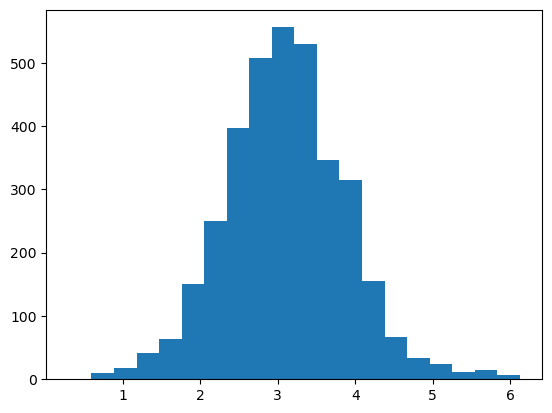

In [67]:
plt.hist(Xhat[0,:], bins=20)

One last element to note, though, is that the similarity matrix $W$ was previously an $m \times m$ matrix (number of users by number of users), whereas now it is an $n \times n$ matrix.  Depending on the number of users and items one of these could be much larger than the other, so one should take this into account regarding memory considerations.  Finally, we'll note that for an actual production system, neither of these matrices would be possible to form directly, so instead it's more common to just store some set of nearest neighbors for each user/item, rather than the entire matrix.

_______